<a id=top-page></a>

# `pykitPIV` demo: Create a **TensorFlow** or **Keras** data loader for **pykitPIV**-generated images

In this Jupyter notebook, we  create a **TensorFlow**-compatible (or **Keras**-compatible) data loader for **pykitPIV**-generated images that can be readily used for training ML algorithms. 

We use the ``PIVDatasetTF`` class from the ``ml`` module
which is a subclass of **TensorFlow**'s [``tf.keras.utils.PyDataset``](https://www.tensorflow.org/api_docs/python/tf/keras/utils/PyDataset).

We then use the **TensorFlow**'s [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) to handle loading training and testing samples.

You can learn more about the methodology of using datasets and data loaders
[in this TensorFlow documentation](https://www.tensorflow.org/guide/data).

<div class="alert alert-block alert-info" style="margin-top: 20px">
<font size="3"><strong>Table of contents:</strong></font>
<br>
<ol>
    <li><a href="#PIVDatasetTF-class">The <code>PIVDatasetTF</code> class </a></li>
    <li><a href="#create-dataset-dataloaders">Create TensorFlow-compatible data loaders for <code>pykitPIV</code> images</a></li>
        <ul>
        <li><a href="#upload-images">Upload pykitPIV-generated images </a></li>
        <li><a href="#create-dataset">Create a <code>tf.keras.utils.PyDataset</code>code</a></li>
        <li><a href="#create-dataloader">Create dataloaders with train and test samples</a></li>
        </ul>
</ol>
<p></p>
</div>
<br>

***

In [1]:
import numpy as np
import h5py
from tensorflow.keras.utils import PyDataset
import tensorflow as tf
import matplotlib.pyplot as plt
import cmcrameri.cm as cmc

2025-05-19 17:49:51.600078: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
save_images = False
filename = None

<a id=PIVDataset-class></a>

***

## The ``PIVDatasetTF`` class

[Go to the top](#top-page)

**pykitPIV** provides the ``PIVDatasetTF`` class that is a subclass of the ``tf.keras.utils.PyDataset`` class.
It implements three standard methods: ``__init__``, ``__len__``, and ``__getitem__``. 

This class  can be readily imported from the ``ml`` module:

In [3]:
from pykitPIV import PIVDatasetTF

<a id=create-dataloaders></a>

***

## Create **TensorFlow**-compatible data loaders for **pykitPIV** images

[Go to the top](#top-page)

<a id=upload-images></a>

### Upload **pykitPIV**-generated images 

[Go to the top](#top-page)

We assume that the PIV/BOS images have been saved and are stored under the following ``path``:


In [4]:
path = '../docs/data/pykitPIV-dataset-10-PIV-pairs-256-by-256.h5'

If you don't have the desired PIV/BOS dataset yet, you can use the generic script,
``/scripts/pykitPIV-generate-images.py``, and run it with, e.g.:

```
python pykitPIV-generate-images.py --n_images 10 --size_buffer 10 --image_height 256 --image_width 256
```

<a id=create-dataset></a>

### Create a ``tf.keras.utils.PyDataset``

[Go to the top](#top-page)

We instantiate an object of the ``PIVDatasetTF`` class:

In [5]:
PIV_data = PIVDatasetTF(dataset=path)

Thanks to the ``__len__`` method, we can now execute the ``len()`` command on the object. This will return the total number of PIV image pairs in the uploaded dataset.

In [6]:
len(PIV_data)

10

Thanks to the ``__getitem__`` method, we can access the data sample at a given index:


In [7]:
(I, target) = PIV_data[2]

In [8]:
I.shape

(2, 256, 256)

In [9]:
target.shape

(2, 256, 256)

or, at multiple indices:

In [10]:
(I, target) = PIV_data[2:7]

You can use the indexing to visualize the first few samples from the dataset:

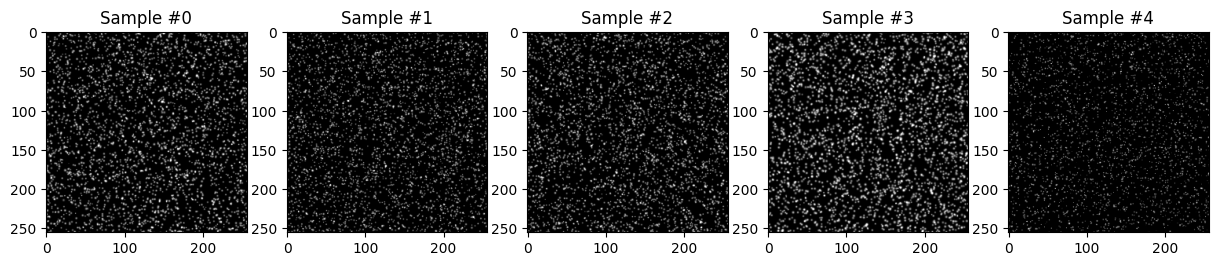

In [11]:
n_samples = 5

fig = plt.figure(figsize=(n_samples*3, 5))
spec = fig.add_gridspec(ncols=n_samples, 
                        nrows=1, 
                        width_ratios=[1 for i in range(0,n_samples)], 
                        height_ratios=[1])

for i in range(0,n_samples):
    I, target = PIV_data[i]
    f = fig.add_subplot(spec[0,i])
    plt.imshow(I[0,:,:], cmap='Greys_r')
    plt.title('Sample #' + str(i))

<a id=create-dataloader></a>

### Create data loaders with train and test samples

[Go to the top](#top-page)

First, we allow the user to create custom composition of data transforms that will augment the
train and test datasets. 

These has to be callables.

In [12]:
transform = None

In [13]:
def transform(sample):

    image, target = sample

    image = tf.cast(image, tf.float32)
    target = tf.cast(target, tf.float32)

    if tf.random.uniform(()) > 0.5:
        
        image = tf.image.flip_left_right(image)
        target = tf.image.flip_left_right(target)

    return image, target

Next, we create train and test datasets using an instance of ``PIVDataset`` for each.

The first method assumes that you have a separate file for the train and test samples:

In [14]:
path_train = '../docs/data/pykitPIV-dataset-10-PIV-pairs-256-by-256.h5'
path_test = '../docs/data/pykitPIV-dataset-10-PIV-pairs-256-by-256.h5'

therefore, you can create:

In [15]:
train_dataset = PIVDatasetTF(dataset=path_train, transform=transform)
test_dataset = PIVDatasetTF(dataset=path_test, transform=transform)

In [16]:
(I, target) = train_dataset[0]

In [17]:
I.shape

TensorShape([2, 256, 256])

In [18]:
target.shape

TensorShape([2, 256, 256])

The second method is to upload the dataset dictionary directly, assuming that you have one containing training and
one containing testing samples. This gives the user a chance for a more flexible train/test split. Note that the
dictionary has to store image intensities under the key ``"I"`` and image targets under the key ``"targets"``.

In [19]:
from pykitPIV import Image

image = Image()

tensors_dictionary_uploaded_train = image.upload_from_h5(filename=path_train)
tensors_dictionary_uploaded_test = image.upload_from_h5(filename=path_test)

In [20]:
dataset_train = {"I" : tensors_dictionary_uploaded_train["I"],
                 "targets" : tensors_dictionary_uploaded_train["targets"]}
dataset_test = {"I" : tensors_dictionary_uploaded_test["I"],
                "targets" : tensors_dictionary_uploaded_train["targets"]}

In an analogous way, you can create:

In [21]:
train_dataset = PIVDatasetTF(dataset=dataset_train, transform=transform)
test_dataset = PIVDatasetTF(dataset=dataset_test, transform=transform)

In [22]:
(I, target) = train_dataset[0]

In [23]:
I.shape

TensorShape([2, 256, 256])

In [24]:
target.shape

TensorShape([2, 256, 256])

Now we can create an object of `tf.data.Dataset` which gives us access to various methods, such as mini-batching or shuffling.

In [25]:
def dataset_from_pydataset(py_dataset):
    
    def generator():
        
        for i in range(len(py_dataset)):
            
            yield py_dataset[i]
    
    sample_x, sample_y = py_dataset[0]
    
    output_signature = (tf.TensorSpec(shape=sample_x.shape, dtype=tf.float32),
                        tf.TensorSpec(shape=sample_y.shape, dtype=tf.float32))

    return tf.data.Dataset.from_generator(generator, output_signature=output_signature)

We can now visualize the first batch of five images:

In [26]:
train_loader = dataset_from_pydataset(train_dataset).shuffle(10).batch(5)

In [27]:
train_I, train_targets = next(iter(train_loader))

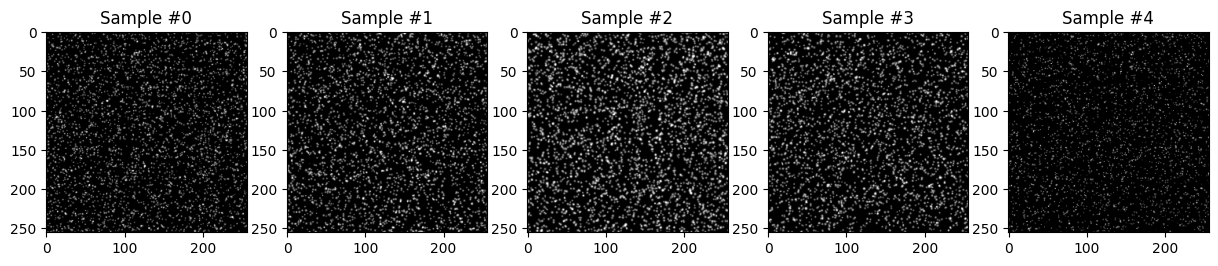

In [28]:
n_samples = 5

fig = plt.figure(figsize=(n_samples*3, 5))
spec = fig.add_gridspec(ncols=n_samples, 
                        nrows=1, 
                        width_ratios=[1 for i in range(0,n_samples)], 
                        height_ratios=[1])

for i in range(0,n_samples):
    
    f = fig.add_subplot(spec[0,i])
    plt.imshow(train_I[i,0,:,:], cmap='Greys_r')
    plt.title('Sample #' + str(i))

And we can also visualize the next (different) batch of five images:

In [29]:
train_loader = dataset_from_pydataset(train_dataset).shuffle(10).batch(5)

In [30]:
train_I, train_targets = next(iter(train_loader))

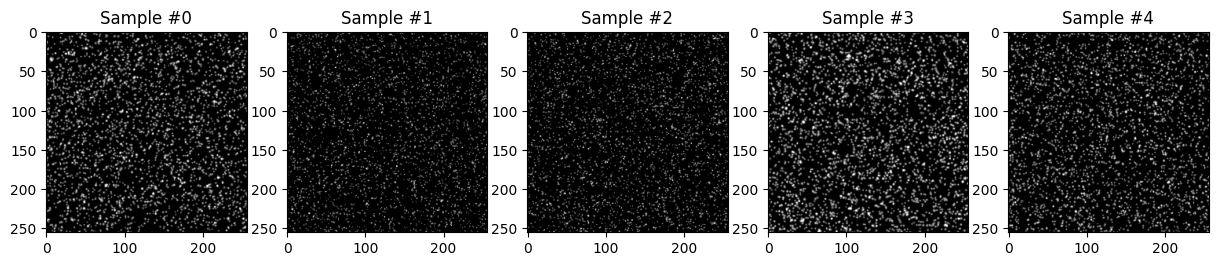

In [31]:
n_samples = 5

fig = plt.figure(figsize=(n_samples*3, 5))
spec = fig.add_gridspec(ncols=n_samples, 
                        nrows=1, 
                        width_ratios=[1 for i in range(0,n_samples)], 
                        height_ratios=[1])

for i in range(0,n_samples):
    
    f = fig.add_subplot(spec[0,i])
    plt.imshow(train_I[i,0,:,:], cmap='Greys_r')
    plt.title('Sample #' + str(i))

***

© K. Zdybał, C. Mucignat, S. Kunz, I. Lunati (2025)